## 航空宇宙情報システム学第二

<h1><center> 第9回 $k$-means法によるクラスタリング </center> </h1>

<center>

2023年6月13日

担当教員: 矢入健久

e-mail: yairi@g.ecc.u-tokyo.ac.jp
</center>

# はじめに

前回は、教師なし学習の代表選手として、主成分分析(PCA)による次元削減・特徴抽出を紹介しました。今回は、教師なし学習のもう一つの古典的・代表的なテーマとして、クラスタリングという話題を取り上げます。

クラスタリングとは、一言でいえば、データの「グループ分け」です。ただし、前々回に話した「分類」では訓練データにはあらかじめ各サプルがどのクラス(カテゴリー)に分類されるべきかという情報が「ラベル」として与えられていたのに対して、クラスタリングでは「ラベル」が与えられません。そのため、<font color="red">データサンプル同士の類似性や、データ分布の構造などに基づいてグループ分けをする</font>ことになります。

# 例題: 2次元データ

言葉で説明するよりも具体的な例を見た方が早いので、早速、簡単な例題を考えてみます。今、次のような2次元(2変数)のデータ点が20個与えられているとします。
```
[1.03,0.07],[-0.78,0.79],[-2.09,0.90],[0.84,0.32],[2.22,0.15],[-3.06,1.46],[0.76,-1.15],[-1.93,1.29],[-0.55,0.84],[1.55,0.12],[-1.03,-0.27],[1.82,-0.86],[-1.64,-0.55],[-1.49,1.55],[-0.08,1.84],[1.95,-2.68],[1.38,-1.09],[1.81,-1.77],[1.33,-0.87],[-2.05,-0.10]
```
2変数とは言え、数値を見ただけではどういうデータの分布になっているのか分からないので、散布図を描いてみます。


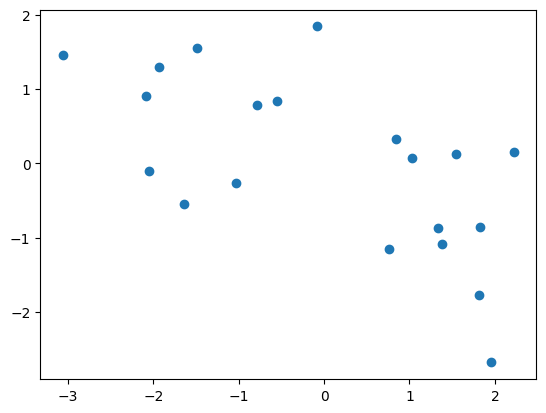

In [ ]:
import numpy as np
import numpy.linalg as la # 後で使う
import matplotlib.pyplot as plt
import pandas as pd # 後で使う

# 例題データ
X = np.array([[1.03,0.07],[-0.78,0.79],[-2.09,0.90],[0.84,0.32],[2.22,0.15],[-3.06,1.46],[0.76,-1.15],[-1.93,1.29],[-0.55,0.84],[1.55,0.12],[-1.03,-0.27],[1.82,-0.86],[-1.64,-0.55],[-1.49,1.55],[-0.08,1.84],[1.95,-2.68],[1.38,-1.09],[1.81,-1.77],[1.33,-0.87],[-2.05,-0.10]])
# 散布図
plt.scatter(X[:,0],X[:,1])

散布図を見てみると、左上と右下の2グループに分けられそうです。
そこで、次のように**手動で**各サンプルにグループ0 とグループ1のラベルを付けてみます。
```
y = [0,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,0,0,0,1]
```
そして、所属するグループごとに色を分けて再度散布図を描いてみます。


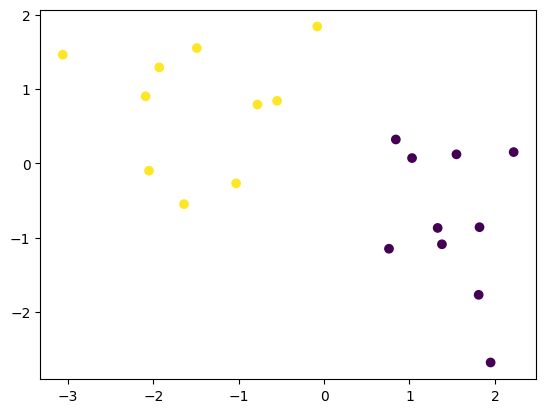

In [ ]:
# 手動で付けたラベル(グループ番号)
y = [0,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,0,0,0,1]
plt.scatter(X[:,0],X[:,1],c=y)

上では、手動で、すなわち、人間が考えて、データのグループ分けをしましたが、<font color="blue">このグループ分け作業を機械にやらせるのが**クラスタリング**</font>です。

# $k$-means ($k$-平均)法によるクラスタリング

## 距離と類似度

クラスタリングの基本方針（の一つ）は、「似たもの同士をグループにする」というシンプルで分かりやすいものです。
では、何をもって「似ている」とみなすかということですが、最も簡単なのは、「説明変数（一般にはベクトル）の**(ユークリッド)距離が近い**」$=$ 「類似している」と考えることです。言い換えれば、「非類似度 = 2つのサンプルの二乗距離」、すなわち、
$$
dissimilarity(\boldsymbol{x}_i, \boldsymbol{x}_j) \equiv \Vert \boldsymbol{x}_i - \boldsymbol{x}_j\Vert^2
$$
と考えるということです。

ただし、ユークリッド距離は高次元では有用な情報を持たない（情報がノイズに埋もれてしまう）という「次元の呪い」(curse of dimensionality)という有名な問題が存在します。

## 点群間の距離の効率的な計算
点群 $\boldsymbol{X}=\left[\boldsymbol{x}_0, \boldsymbol{x}_1, \ldots, \boldsymbol{x}_{m-1}\right]^\top$ と、点群$\boldsymbol{Y}=\left[\boldsymbol{y}_0, \boldsymbol{y}_1, \ldots, \boldsymbol{y}_{n-1}\right]^\top$ に対して、
$$
d_{i,j}^2 = \Vert \boldsymbol{x}_i - \boldsymbol{y}_j \Vert^2
$$
を、$i=0,1,\ldots,m-1$, $j=0,1,\ldots,n-1$ について求め、
$$
\boldsymbol{D}_{\boldsymbol{X},\boldsymbol{Y}} = \left[
\begin{matrix}
d_{0,0}^2 & d_{0,1}^2 & \cdots & d_{0,n-1}^2 \\
d_{1,0}^2 & d_{1,1}^2 & \cdots & d_{1,n-1}^2 \\
\vdots & \vdots & \vdots & \vdots \\
d_{m-1,0}^2 & d_{m-1,1}^2 & \cdots & d_{m-1,n-1}^2 \\
\end{matrix}
\right]
$$
という形で求めたいとします。

例えば、$n=2$として
```
Y = np.array([[-1.0,1.0],[1.0,-1.0]])
```
のとき、$\boldsymbol{X}$に含まれる20個の点と、$\boldsymbol{Y}$に含まれる2個の点と間のユークリッド二乗距離を求めることを考えてみましょう。

一番素朴なのは、`for`文を二重に回して$20 \times 2 = 40$個の距離を求めることです。具体的には、次のようになります。



In [ ]:
# Y は2個の点とする
Y = np.array([[-1.0,1.0],[1.0,-1.0]])
# i,j成分が、x_i と y_j とのユークリッド距離の2乗となるような20x2の行列。成分を初期化
D = np.zeros((20,2))
# i=0,1,...,19, j=0,1 について、x_i と y_j との二乗距離を計算
for i in range(20):
  for j in range(2):
    D[i,j] = np.sum((X[i,:] - Y[j,:])**2)
print(D)


[[ 4.9858  1.1458]
 [ 0.0925  6.3725]
 [ 1.1981 13.1581]
 [ 3.848   1.768 ]
 [11.0909  2.8109]
 [ 4.4552 22.5352]
 [ 7.7201  0.0801]
 [ 0.949  13.829 ]
 [ 0.2281  5.7881]
 [ 7.2769  1.5569]
 [ 1.6138  4.6538]
 [11.412   0.692 ]
 [ 2.8121  7.1721]
 [ 0.5426 12.7026]
 [ 1.552   9.232 ]
 [22.2449  3.7249]
 [10.0325  0.1525]
 [15.569   1.249 ]
 [ 8.9258  0.1258]
 [ 2.3125 10.1125]]


これはこれで正しいのですが、<font color="red">NumPyの計算効率を最大化するには、「できるだけ`for`文を使わない」こと</font>が大事です。今、
$$
d_{i,j}^2 = \Vert \boldsymbol{x}_i - \boldsymbol{y}_j \Vert^2
= \Vert \boldsymbol{x}_i \Vert^2 + \Vert \boldsymbol{y}_j \Vert^2 - 2 \boldsymbol{x}_i \cdot \boldsymbol{y}_j
$$
であることから、
$$
\boldsymbol{D}_{\boldsymbol{X},\boldsymbol{Y}} =
\left[
\begin{matrix}
\Vert \boldsymbol{x}_0 \Vert^2 & \Vert \boldsymbol{x}_0 \Vert^2 & \cdots & \Vert \boldsymbol{x}_0 \Vert^2 \\
\Vert \boldsymbol{x}_1 \Vert^2 & \Vert \boldsymbol{x}_1 \Vert^2 & \cdots & \Vert \boldsymbol{x}_1 \Vert^2 \\
\vdots & \vdots & \vdots & \vdots \\
\Vert \boldsymbol{x}_{m-1} \Vert^2 & \Vert \boldsymbol{x}_{m-1} \Vert^2 & \cdots & \Vert \boldsymbol{x}_{m-1} \Vert^2 \\
\end{matrix}
\right]
+
\left[
\begin{matrix}
\Vert \boldsymbol{y}_0 \Vert^2 & \Vert \boldsymbol{y}_1 \Vert^2 & \cdots & \Vert \boldsymbol{y}_{n-1} \Vert^2 \\
\Vert \boldsymbol{y}_0 \Vert^2 & \Vert \boldsymbol{y}_1 \Vert^2 & \cdots & \Vert \boldsymbol{y}_{n-1} \Vert^2 \\
\vdots & \vdots & \vdots & \vdots \\
\Vert \boldsymbol{y}_0 \Vert^2 & \Vert \boldsymbol{y}_1 \Vert^2 & \cdots & \Vert \boldsymbol{y}_{n-1} \Vert^2 \\
\end{matrix}
\right]
- 2 \cdot
\left[
\begin{matrix}
\boldsymbol{x}_0 \cdot \boldsymbol{y}_0 & \boldsymbol{x}_0 \cdot \boldsymbol{y}_1 & \cdots & \boldsymbol{x}_0 \cdot \boldsymbol{y}_{n-1} \\
\boldsymbol{x}_1 \cdot \boldsymbol{y}_0 & \boldsymbol{x}_1 \cdot \boldsymbol{y}_1 & \cdots & \boldsymbol{x}_1 \cdot \boldsymbol{y}_{n-1} \\
\vdots & \vdots & \vdots & \vdots \\
\boldsymbol{x}_{m-1} \cdot \boldsymbol{y}_0 & \boldsymbol{x}_{m-1} \cdot \boldsymbol{y}_1 & \cdots & \boldsymbol{x}_{m-1} \cdot \boldsymbol{y}_{n-1}
\end{matrix}
\right]
$$

となり、これを使えば<font color="blue">`for`文を使わずに、しかもたった1行で距離の行列を求める</font>ことができます。



In [ ]:
np.sum(X**2,axis=1).reshape((-1,1))

array([[ 1.0658],
       [ 1.2325],
       [ 5.1781],
       [ 0.808 ],
       [ 4.9509],
       [11.4952],
       [ 1.9001],
       [ 5.389 ],
       [ 1.0081],
       [ 2.4169],
       [ 1.1338],
       [ 4.052 ],
       [ 2.9921],
       [ 4.6226],
       [ 3.392 ],
       [10.9849],
       [ 3.0925],
       [ 6.409 ],
       [ 2.5258],
       [ 4.2125]])

In [ ]:
np.sum(Y**2,axis=1).reshape((1,-1))

array([[2., 2.]])

In [ ]:
# for 文を使わずに、XとYの各行の間の二乗距離を求める
np.sum(X**2,axis=1).reshape((-1,1)) + np.sum(Y**2,axis=1).reshape((1,-1)) - 2*np.dot(X,Y.T)

array([[ 4.9858,  1.1458],
       [ 0.0925,  6.3725],
       [ 1.1981, 13.1581],
       [ 3.848 ,  1.768 ],
       [11.0909,  2.8109],
       [ 4.4552, 22.5352],
       [ 7.7201,  0.0801],
       [ 0.949 , 13.829 ],
       [ 0.2281,  5.7881],
       [ 7.2769,  1.5569],
       [ 1.6138,  4.6538],
       [11.412 ,  0.692 ],
       [ 2.8121,  7.1721],
       [ 0.5426, 12.7026],
       [ 1.552 ,  9.232 ],
       [22.2449,  3.7249],
       [10.0325,  0.1525],
       [15.569 ,  1.249 ],
       [ 8.9258,  0.1258],
       [ 2.3125, 10.1125]])

ここでは、numpy の「ブロードキャスト」という機能を使っています。つまり、足し算第１項目
```
np.sum(X**2,axis=1).reshape((-1,1))
```
は、**20行1列**のarray型であり、第２項目
```
np.sum(Y**2,axis=1).reshape((1,-1))
```
は、**1行2列**のarray型です。
これらを演算子`+`で足すと、**20行2列**のarray型となり、
その`(i,j)`成分は`X[i,0]+Y[0,j]`になります。

（1行で済むのであまり必要性はありませんが、）後で使うために関数として定義しておきます。

In [ ]:
# 点群Xと点群Yの各点間の二乗距離を求める関数
def sqdist(X,Y):
  D = np.sum(X**2,axis=1).reshape((-1,1)) + np.sum(Y**2,axis=1).reshape((1,-1)) - 2*np.dot(X,Y.T)
  return D

## クラスターの代表点と各サンプルの割当

$k$-means 法では、各クラスターは**代表点**によって表現され、各データサンプルは、<font color="blue">最も距離が近い代表点のクラスターに割り当てられ</font>ます。

今、<font color="red">左上のグループを「クラスター0」としてその暫定的な代表点を$(-1,1)$、右下のグループを「クラスター1」として暫定的な代表点を、$(1,-1)$</font>としてみましょう。つまり、先程の$\boldsymbol{Y}$
```
Y = np.array([[-1.0,1.0],[1.0,-1.0]])
```
が、2つのクラスターの暫定的な代表点を並べた行列ということになります。
そして、$\boldsymbol{X}$に含まれる20個のデータサンプルと、$\boldsymbol{Y}$に含まれる2個のクラスター代表点との(二乗)距離は、上で説明した`sqdist(X,Y)`関数で求まっています。
後は、各サンプルをクラスター0と1の代表点のうちの近い方に割り当てれば良いですが、これは、numpyの中の`argmin()`関数を使うと簡単にできます。

**(注意)** `Y`をそのまま使っても良いのですが、以下のコードでは、クラスターの代表点(中心点)という意味で新たに`C`という変数を使っています。


In [ ]:
# 暫定的なクラスター代表点 (-1,1),(1,-1)
C = np.array([[-1.0,1.0],[1.0,-1.0]])
# 20個の点と、暫定的なクラスター代表点 (-1,1),(1,-1)との二乗距離の行列
D = sqdist(X,C)
# 20個の点それぞれを、近い方に割り当てる。
asgn = np.argmin(D,axis=1)
# 割当結果を表示
print(asgn)

[1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0]


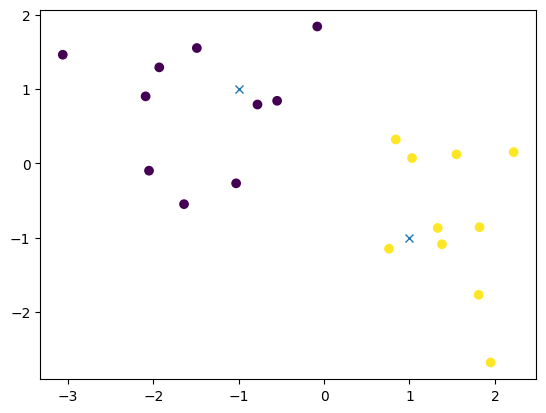

In [ ]:
# 近い方の代表点に割り当てられた結果を色分けして表示
plt.scatter(X[:,0],X[:,1],c=asgn)
# 各クラスターの代表点を表示
plt.plot(C[:,0],C[:,1],'x')

## クラスタリングの平方誤差和

$k$-means法ではクラスタリング(グループ分け)の良し悪しを図る指標として、<font color="red">各点の割り当てられたクラスタ代表点との二乗距離の和</font>が用いられます。これは、平方誤差和(sum of squared errors: SSE)とかディストーション(distortion)と呼ばれます。
具体的に計算してみると、

In [ ]:
# 1つ1つ計算する場合(分かりやすい)
sse = 0.0
for i in range(20):
  # i 番目のサンプルが割り当てられたクラスタはasgn[i] (0か1)
  sse += np.sum((X[i,:] - C[asgn[i],:])**2)
print("SSE:", sse)

# まとめて計算
sse = np.sum((X - C[asgn,:])**2)
print("SSE:",sse)

SSE: 29.0618
SSE: 29.0618


## クラスタ代表点（中心）の更新

ここまでは、２つのクラスターの代表点を暫定的に$(-1,1)$,$(1,-1)$のように決めましたが、上の散布図を見て分かるように、それらの<font color="red">クラスター代表点は各色分けされたデータサンプルの中心（平均）から少し外れています</font>。そこで、<font color="blue">各クラスターに割り当てられたサンプル集合ごとに、その中心（平均）を新たなクラスター代表点として更新</font>します。(これが、「$k$-means(平均)」法の名前の由来です。)

更新されたクラスター代表点を使って、SSEを計算し直すと、先程よりも小さい値になっていることが分かります。

[[-1.47   0.775]
 [ 1.469 -0.776]]
SSE: 23.64518


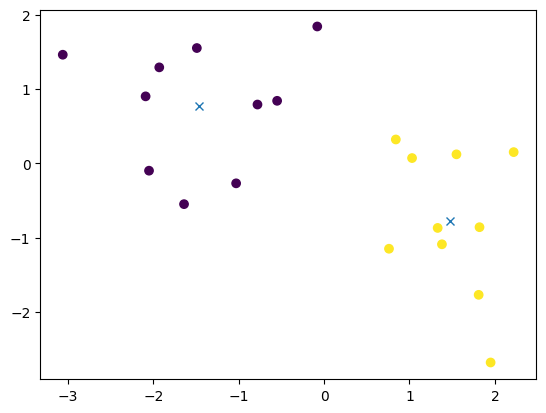

In [ ]:
# 各クラスタ(k=0,1)ごとに、割り当てられたサンプルの平均でクラスタ代表を更新
for k in range(2):
  C[k,:] = np.mean(X[asgn==k,:],axis=0)
print(C)
plt.scatter(X[:,0],X[:,1],c=asgn)
# 更新された各クラスターの代表点を表示
plt.plot(C[:,0],C[:,1],'x')

# 更新後のSSE
sse = np.sum((X - C[asgn,:])**2)
print("SSE:",sse)

## $k$-means クラスタリングの基本アルゴリズム

以上の話を一旦まとめて、$k$-means法によるクラスタリングの手続きを記述すると、次のようになります。

1. クラスター数$k$とともに、各クラスターの代表点の初期値を決定する。
1. 各データサンプルを最も距離の近い代表点のクラスターに割り当てる。
1. 各クラスターごとに、割り当てられたデータサンプルの平均でクラスター代表点を更新する。また、平方誤差和(SSE)を計算する。
1. 収束するまで、2-3のステップを繰り返す。

このうち、ステップ1の「各クラスター代表点の初期値の決定」として最も素朴なのは、
<font color="blue">「$n$個のデータサンプルからランダムに$k$個を選び出し、それらを各クラスター代表の初期値とする」</font>ことです。

また、ステップ4の収束判定としては、
* 各データサンプルの割当が前回から変化しない。
* 各クラスターの代表点の前回からの変化が一定値よりも小さい。
* (単調減少する)SSEの前回からの変化が一定値よりも小さい。

などの基準が使われます。通常、$k$-means法の収束性は高いです。

とりあえず、この方針で例題について、$k$-means法によるクラスタリングをコードにしてみましょう。

Iteration: 0
SSE= 68.90076767676767
Iteration: 1
SSE= 57.459880808080804
Iteration: 2
SSE= 26.91009898989899
Iteration: 3
SSE= 23.64518
Iteration: 4
SSE= 23.64518
[[-1.47   0.775]
 [ 1.469 -0.776]]
[1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0]


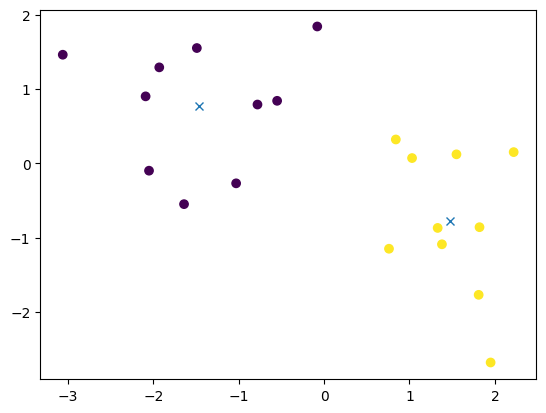

In [ ]:
### k-means 法によるクラスタリング (素朴な初期化)
# データサンプル数
n = X.shape[0]
# クラスター数の決定
K = 2
# クラスター代表点の選定 (データサンプルからランダムに選ぶ)
ix = np.random.choice(n,K,replace=False)
C = X[ix,:]
# 繰り返しの最高回数
itermax = 10
# 繰り返し
for iter in range(itermax):
  print("Iteration:",iter)
  # 二乗距離を計算
  D = sqdist(X,C)
  # 一番近いクラスターに割当
  asgn = np.argmin(D,axis=1)
  # クラスター代表を更新
  for k in range(K):
    C[k,:] = np.mean(X[asgn==k,:],axis=0)
  # SSEを計算
  sse = np.sum((X - C[asgn,:])**2)
  print("SSE=",sse)
  # 収束判定
  if iter >= 1:
    if sse_pre - sse < 1.0e-6:
      break
  sse_pre = sse

# クラスタ中心
print(C)
# クラスタへの割当
print(asgn)

# 色分け散布図
plt.scatter(X[:,0],X[:,1],c=asgn)
# 更新された各クラスターの代表点を表示
plt.plot(C[:,0],C[:,1],'x')


この自作$k$-meansクラスタリングを**関数化**してみます。引数としては、データ$\boldsymbol{X}$とクラスター数$K$を与えることにします。また、戻り値として、
* クラスター中心の座標を重ねた行列
* 各サンプルがどのクラスターに割り当てられたか
* SSEの値

をタプルで返すことにします。

In [ ]:
### k-means 法によるクラスタリング (素朴な初期化)
def kmeans(X,K=2):
  # データサンプル数
  n = X.shape[0]
  # クラスター代表点の選定 (データサンプルからランダムに選ぶ)
  ix = np.random.choice(n,K,replace=False)
  C = X[ix,:]
  # 繰り返しの最高回数(本来はこれも引数で設定するのが好ましい)
  itermax = 100
  # 繰り返し
  for iter in range(itermax):
    print("Iteration:",iter)
    # 二乗距離を計算
    D = sqdist(X,C)
    # 一番近いクラスターに割当
    asgn = np.argmin(D,axis=1)
    # クラスター代表を更新
    for k in range(K):
      C[k,:] = np.mean(X[asgn==k,:],axis=0)
    # SSEを計算
    sse = np.sum((X - C[asgn,:])**2)
    print("SSE=",sse)
    # 収束判定
    if iter >= 1:
      if sse_pre - sse < 1.0e-6:
        break
    sse_pre = sse
  return C,asgn,sse


## クラスター代表点の初期化方法

$k$-means法の実用的な問題点として**初期値依存性**、つまり、最初に暫定的に決めたクラスター代表点の決め方によって結果が異なることがあります。<font color="red">この性質はクラスター数($k$)が増えると顕著</font>になります。

少し味方を変えると、$k$-means法は、SSEを最小化するようなデータのクラスターへの割当とクラスター代表点を見つけようとするのですが、局小解に陥り易いという問題があります。

試しに、$K=4$として何度か$k$-means法を行ってみてください。収束後のSSEの値が
$17.55 \sim 12.66$の範囲で変動することが分かると思います。


Iteration: 0
SSE= 16.810834920634917
Iteration: 1
SSE= 14.28587619047619
Iteration: 2
SSE= 12.658707142857143
Iteration: 3
SSE= 12.658707142857143
[[-1.42571429  1.23857143]
 [-1.57333333 -0.30666667]
 [ 1.41        0.165     ]
 [ 1.50833333 -1.40333333]]
[2 0 0 2 2 0 3 0 0 2 1 3 1 0 0 3 3 3 3 1]


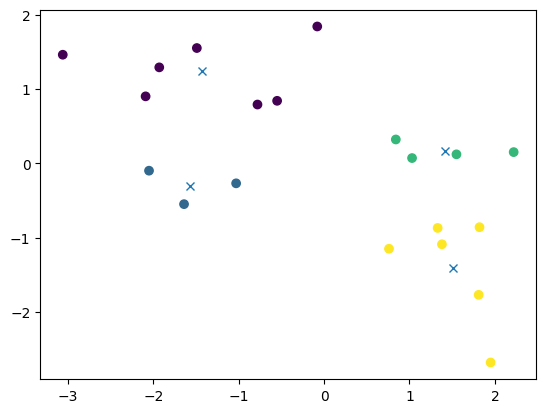

In [ ]:
C,asgn,sse = kmeans(X,4)

# クラスタ中心
print(C)
# クラスタへの割当
print(asgn)

# 色分け散布図
plt.scatter(X[:,0],X[:,1],c=asgn)
# 更新された各クラスターの代表点を表示
plt.plot(C[:,0],C[:,1],'x')


この問題への対策としては、まず一番簡単なのが、
* ランダムに初期解を与えて複数回クラスタリングを行い、SSEの値が最も小さかったときの結果を採用する。

ですが、完全にランダムに初期解を選ぶのではなく、クラスター代表同士の距離がある程度離れるように初期解をサンプリングする方法もあります。代表として、$k$-means++法があります。自分で実装するのはちょっと大変ですが、[scikit-learn で提供されている $k$-means法](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)にはそのような方法がオプションで用意されているので、**使ってみましょう。**

SSE= 12.658707142857143


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


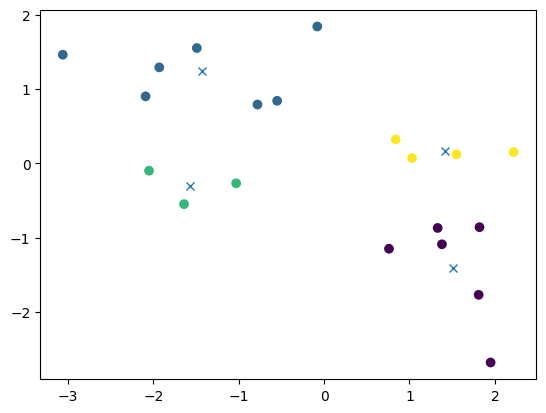

In [ ]:
# Scikit-learn の k-means法
from sklearn.cluster import KMeans
# デフォルトで、k-means++ の初期化が適用される。
km_res = KMeans(n_clusters=4).fit(X)
# SSEの値(inertia_属性)
print("SSE=",km_res.inertia_)
# 色分け散布図
# 色分け散布図
plt.scatter(X[:,0],X[:,1],c=km_res.labels_)
# 更新された各クラスターの代表点(cluster_centers_属性)を表示
plt.plot(km_res.cluster_centers_[:,0],km_res.cluster_centers_[:,1],'x')


## 例題: クラスタリングでお札の真偽は判定できるか？

もう少しリアルな例題として、ロジスティック回帰の際に使った「紙幣の真偽判定データセット」(Banknote Authentication Dataset)を使ってみましょう。

In [ ]:
# データを読み込み、訓練、テストデータを作成
dfbn = pd.read_csv('/content/drive/My Drive/data_banknote_authentication.txt',header=None,names=["x1","x2","x3","x4","y"])


このデータは4つの説明変数がありますが、とりあえず、最初の2つの説明変数を横軸、縦軸にして、全データを区別せずに散布図を描いた後、
真のラベル（真札:$y=0$, 偽札:$y=1$）で色付けして散布図を描いてみます。

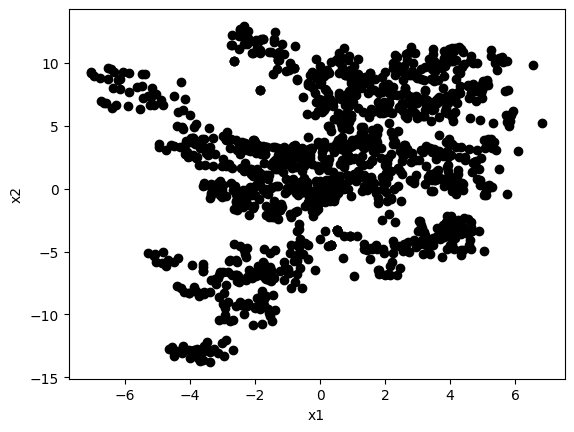

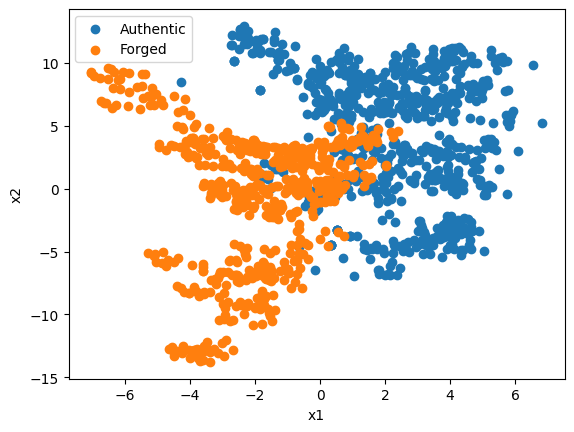

In [ ]:
#まず、色なしで全サンプルをプロット
plt.scatter(dfbn.x1,dfbn.x2,c="k")
plt.xlabel("x1")
plt.ylabel("x2")


#次に、真か偽かで色付けしてプロット
plt.figure()
plt.scatter(dfbn[dfbn.y==0].x1,dfbn[dfbn.y==0].x2,label="Authentic")
plt.scatter(dfbn[dfbn.y==1].x1,dfbn[dfbn.y==1].x2,label="Forged")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

真札と偽札とで、確かに分布は異なっていますが、それらが2つのクラスターとして分けられるかは微妙な感じがしますね。

では実際に、ラベルを使わず、$k$-means法でクラスタリングしてみましょう。

Iteration: 0
SSE= 52466.465110030724
Iteration: 1
SSE= 47375.56511638804
Iteration: 2
SSE= 45660.07645078271
Iteration: 3
SSE= 44952.864616700295
Iteration: 4
SSE= 44684.324362566855
Iteration: 5
SSE= 44527.58687701709
Iteration: 6
SSE= 44420.823168306655
Iteration: 7
SSE= 44279.903888302244
Iteration: 8
SSE= 44143.81767231149
Iteration: 9
SSE= 44065.3567962
Iteration: 10
SSE= 44053.22641358708
Iteration: 11
SSE= 44049.95031812096
Iteration: 12
SSE= 44049.44292337676
Iteration: 13
SSE= 44049.44292337676


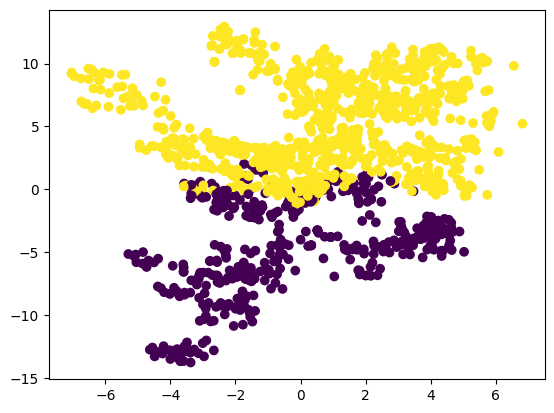

In [ ]:
Xbn = dfbn.iloc[:,:4].values
C,asgn,sse = kmeans(Xbn,2)

# 色付き散布図でプロット
plt.scatter(Xbn[:,0],Xbn[:,1],c=asgn)

残念ながらというか、予想通りというか、お札の真偽とは無関係なグループ化になってしまいました。
もしかしたら、自分で書いたコードに問題があるかもしれないので、Scikit-learn の$k$-means法でも試してみます。

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SSE: 24567.219116921166


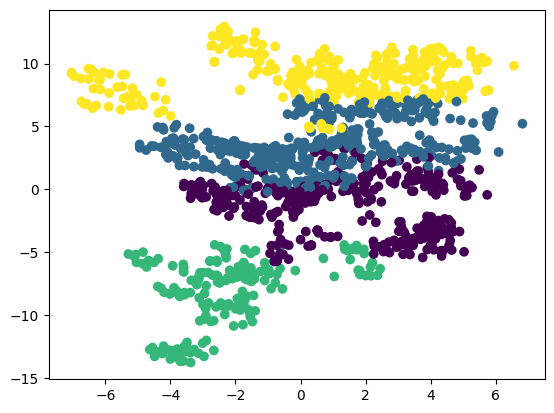

In [ ]:
km_res = KMeans(n_clusters=4).fit(Xbn)
plt.scatter(Xbn[:,0],Xbn[:,1],c=km_res.labels_)
print("SSE:",km_res.inertia_)

やはり同じ結果になりました。距離に基づくクラスタリングの結果が、必ずしも人間が有益だと考えるクラスラベルと一致しない、ということを表しています。